Author: Judit Lozano Gondolbeu

### Libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import warnings
import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, ConfusionMatrixDisplay, roc_curve, precision_recall_curve,\
                             classification_report,  accuracy_score, f1_score, recall_score, precision_score, confusion_matrix
import scikitplot as skplt
import eli5
from eli5.sklearn import PermutationImportance
from sklearn.datasets import make_hastie_10_2
from sklearn.inspection import PartialDependenceDisplay
import shap
import lightgbm as lgbm


warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 5000)


In [2]:
with open('../data/train_ridge.pickle', 'rb') as f:
     X_train, y_train, X_test, y_test = pickle.load(f)
      # display dataset
print(X_train.head())

     C_MNTH    C_WDAY    C_HOUR    C_RCFG    C_WTHR    C_RALN    C_TRAF  \
0 -1.129054  1.375704  0.651298 -0.824320  0.948994  0.531235 -0.363466   
1 -1.129054 -0.417392 -0.779007 -0.824320 -0.246324 -0.353054 -1.353824   
2  0.183556 -0.417392 -0.646253  1.246626 -0.246324 -0.353054 -0.318034   
3  1.797639 -0.899118 -0.359585  1.246626 -0.246324 -0.353054  0.851024   
4 -1.413490 -0.504111 -0.556747 -0.605457  0.909085 -1.210185 -1.353824   

     V_TYPE    P_SAFE    V_YEAR     P_AGE     P_SEX    PP_CAR  
0 -0.251504 -0.225190 -0.118230 -0.963827  0.816670 -1.450629  
1 -0.251504 -0.225190  0.097020 -0.591176 -1.219878  0.839152  
2 -0.251504  0.074408 -0.154105 -0.692808 -1.219878  0.839152  
3 -0.711926 -0.369937  3.433395 -0.828318 -1.219878  0.174065  
4 -0.251504 -0.225190 -0.261729 -0.658931 -1.219878  0.839152  


In [3]:
#Cargamos el modelo entrenado y optimizado
with open("../models/model_lgb_final.pckl", "rb") as f:
    model = pickle.load(f)

Antes de comenzar con el apartado de interpretabilidad comentaremos unos puntos en relación a la ejecución del modelo SHAP:

### Ejecutando SHAP 

Parece haber problemas para ejecutar el modelo SHAP desde GridSearchCV. A continuación, una imagen del error:

![image.png](../images/img_error.png))

Hemos comprobado que el modelo entrenado si ha funcionado bien con permutation importance y partial dependence plots pero entrenaremos de nuevo el modelo para evitar que el componente aleatorio intercepte en los resultados de interpretabilidad al usar modelos entrenados en dos momentos diferentes.

En conclusión, parece ser que SHAP necesita que el modelo entrenado esté guardado en una variable aparte para su correcta ejecución.

In [4]:
parametros= model.best_params_
print(parametros)

{'class_weight': {0: 0.2, 1: 0.8}, 'learning_rate': 0.01, 'n_estimators': 1000, 'num_leaves': 50}


In [5]:
lgb_model = lgbm.LGBMClassifier(**parametros)

In [6]:
lgb_model.fit(X_train, y_train)

LGBMClassifier(class_weight={0: 0.2, 1: 0.8}, learning_rate=0.01,
               n_estimators=1000, num_leaves=50)

### Interpretabilidad
A continuación estudiaremos qué variables tienen la mayor importancia según las predicciones de nuestro modelo.
A nivel global analizaremos estas variables con la permutacion de variables y partial dependence plots.

In [7]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0673 ± 0.0013,PP_CAR
0.0560 ± 0.0034,C_TRAF
0.0347 ± 0.0009,P_SAFE
0.0219 ± 0.0007,V_TYPE
0.0211 ± 0.0003,C_RCFG
0.0195 ± 0.0006,C_RALN
0.0154 ± 0.0010,P_AGE
0.0130 ± 0.0009,C_HOUR
0.0106 ± 0.0003,C_WTHR
0.0082 ± 0.0003,P_SEX


### Interpretación de la importancia segun permutación

Las variables que están más arriba son las variables que nuestro modelo considera más importantes a nivel global.
La columna primera indica cuanto bajaría la precisión del modelo si cambiaramos aleatoriamente los valores para esa determinada variable.

Segun ésta técnica la variable que tiene más importancia para predecir nuestra variable target sería el número de ocupantes por vehículo, la señalización de la carretera y si llevaba o no algun dispositivo de seguridad (cinturón de seguridad, casco etc...)

### Partial Dependence Plots

Podemos entender los partial dependence plots como la relación que explica nuestra variable target en función de las variables explicativas que escojamos. En este sentido procederemos a observar los partial dependence plots para las variables 'numero de ocupantes' (PP_CAR) y 'señalización de la carretera' (C_TRAF).

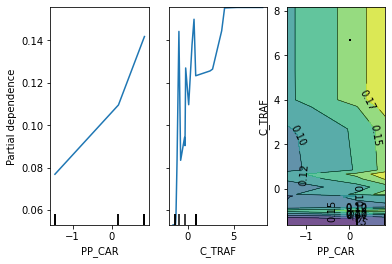

In [8]:
features = [12,6, (12, 6)] #las dos mas significativas segun la interpretabilidad de la permutación
PartialDependenceDisplay.from_estimator(model, X_test, features)

La interpretación de estos gráficos se hace dificultosa porque los valores están transformados. 

Sin embargo, en el gráfico de la izquierda podemos observar que practicamente existe una relación lineal entre el numero de ocupantes que viajan en el coche y los casos donde existe mortalidad. En el caso de la variable C_TRAF la dependencia da saltos habiendo determinados casos que sobresalen en la relación con la variable target. 

Finalmente en la última gráfica se puede observar como estas dos variables en combinación afectan a la variable target en la misma dirección. 

### Interpretabilidad Local con SHAP

Con Shap podemos estudiar la correlación ente cada variable con la variable target para uno o varias filas y ordena las variables segun sus coeficientes absolutos de mayor a menor.

In [9]:
# Create object that can calculate shap values
explainer = shap.TreeExplainer(lgb_model)

# Calculate Shap values
shap_values = explainer.shap_values(X_test)

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test.iloc[0,:])

In [ ]:
#summarizetheeffectsofallthefeatures
shap.summary_plot(shap_values, X_test)

In [ ]:
shap.summary_plot(shap_values[0],features=X_test)

Si analizamos los valores para una única fila el punto donde se diferencia el color rojo del azul es la probabilidad de que ese determinado caso la variable target sea un uno, es decir probabilidad de que ese conductor esté involucrado en un accidente donde habrá algun fallecido. 

Las variables en azul hacen que esa probabilidad baje y las variables en rojo hacen que la probabilidad suba.

### Conclusiones

En este estudio aplicamos herramientas de machine learning para un problema de clasificación donde queremos predecir si habrá o no fatalidades dado un accidente entre los conductores asegurados por las empresas aseguradoras de automóviles con cobertura en Canadá. 

Tras realizar un análisis exploratorio inicial del data set observamos que este está muy desbalanceado y que no hay correlaciones destacables entre las variables que son mayoritariamente de naturaleza categórica.

Para atajar el problema de desbalanceo de datos y tras un procesado y limpieza de las variables del dataset hemos aplicado la técnica de SMOTE combinada con un ligero undersampling para facilitar el entrenado posterior del modelo.

Tras estudiar las métricas con varios modelos, optimización de hiperparámetros y validación cruzada nuestro modelo ganador es el LGBMClassifier. 

En este estudio nos hemos centrado en la información a nivel global ya que nos interesa conocer el número global de conductores involucrados en accidentes con resultado mortal con la intención de estimar las reservas necesarias en caso de indemnización. 

Para un estudio a nivel local donde los objetivos sean el abordaje del cálculo de la prima por ejemplo para un nuevo conductor que quiere asegurarse con la compañia, tendríamos que replantear el estudio completamente dando especial importancia a la parte de interpretabilidad a nivel local para evitar sobretodo posibles sesgos descriminatorios de carácter demográfico. 




Para concluir, estos son los puntos más relevantes que podemos destacar de este estudio de machine learning según nuestro modelo ganador:

    - tipos de vehículos
    - dfs
    - dfs
    - dfs